# Load Dataset

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CxmnmwblpBjFuOlo5vKY")
project = rf.workspace("bestgetsbetter").project("jpj")
version = project.version(1)
dataset = version.download("yolov12")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.3


Extracting Dataset Version Zip to JPJ-1 in yolov12:: 100%|██████████| 2275/2275 [00:00<00:00, 8314.45it/s]


In [2]:
# ============================================================
# INSTALL & IMPORTS
# ============================================================

import os, glob, random, shutil, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import albumentations as A
from tqdm import tqdm

In [3]:
root = dataset.location
print("Dataset root folder:", root)

# Auto-detect all image folders
possible_subfolders = ["train", "valid", "test"]
image_paths = []

for subset in possible_subfolders:
    # Check direct folder: /train/*.jpg
    path1 = os.path.join(root, subset)
    # Check YOLO folder: /train/images/*.jpg
    path2 = os.path.join(root, subset, "images")

    if os.path.exists(path1):
        image_paths.extend(glob.glob(path1 + "/*.jpg"))
        image_paths.extend(glob.glob(path1 + "/*.png"))

    if os.path.exists(path2):
        image_paths.extend(glob.glob(path2 + "/*.jpg"))
        image_paths.extend(glob.glob(path2 + "/*.png"))

# Pick 3 sample images
sample_imgs = image_paths[:3]

print("Found images:", len(image_paths))
print("Selected 3 images:")
for p in sample_imgs:
    print(p)

Dataset root folder: /kaggle/working/JPJ-1
Found images: 1133
Selected 3 images:
/kaggle/working/JPJ-1/train/images/20230619164657_247484_TS_2940_jpg.rf.0598fe72d8309f7f9119efe5811aed8f.jpg
/kaggle/working/JPJ-1/train/images/Malaysia_Dash_Cam_Video_Compilation_14_Malaysian_Dash_Cam_Owners_mp4_15780_jpg.rf.1deeba42732c2ad172a45d12f3660bdd.jpg
/kaggle/working/JPJ-1/train/images/Dash_Cam_Owners_Indonesia_498_June_2023_mp4_3540_jpg.rf.ca270a0bb202cbc8e6448f65522b665f.jpg


# Define Intensity Transformation Functions

In [4]:
# ============================================================
# INTENSITY TRANSFORMATION FUNCTIONS
# ============================================================

def log_transformation(img):
    img = img.astype(np.float32)
    c = 255 / np.log(1 + np.max(img))
    log_img = c * (np.log(img + 1))
    return np.uint8(np.clip(log_img, 0, 255))

def gamma_correction(img, gamma=1.5):
    img_normalized = img / 255.0
    gamma_img = np.power(img_normalized, gamma)
    return np.uint8(gamma_img * 255)

def contrast_stretching(img):
    r_min, r_max = np.min(img), np.max(img)
    stretched = (img - r_min) * (255 / (r_max - r_min))
    return np.uint8(stretched)

def clahe_equalization(img):
    if len(img.shape) == 3: 
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        L, A, B = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        L_clahe = clahe.apply(L)

        final = cv2.merge((L_clahe, A, B))
        return cv2.cvtColor(final, cv2.COLOR_LAB2BGR)
    else:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(img)

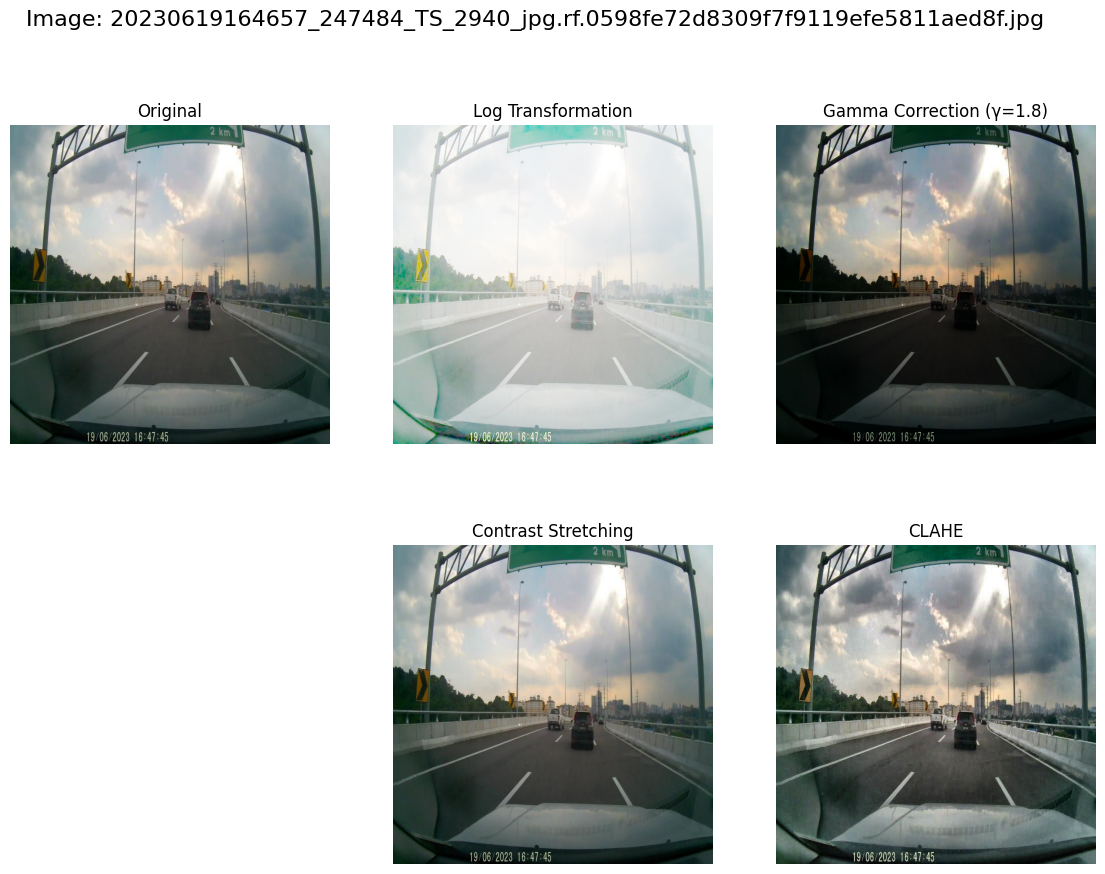

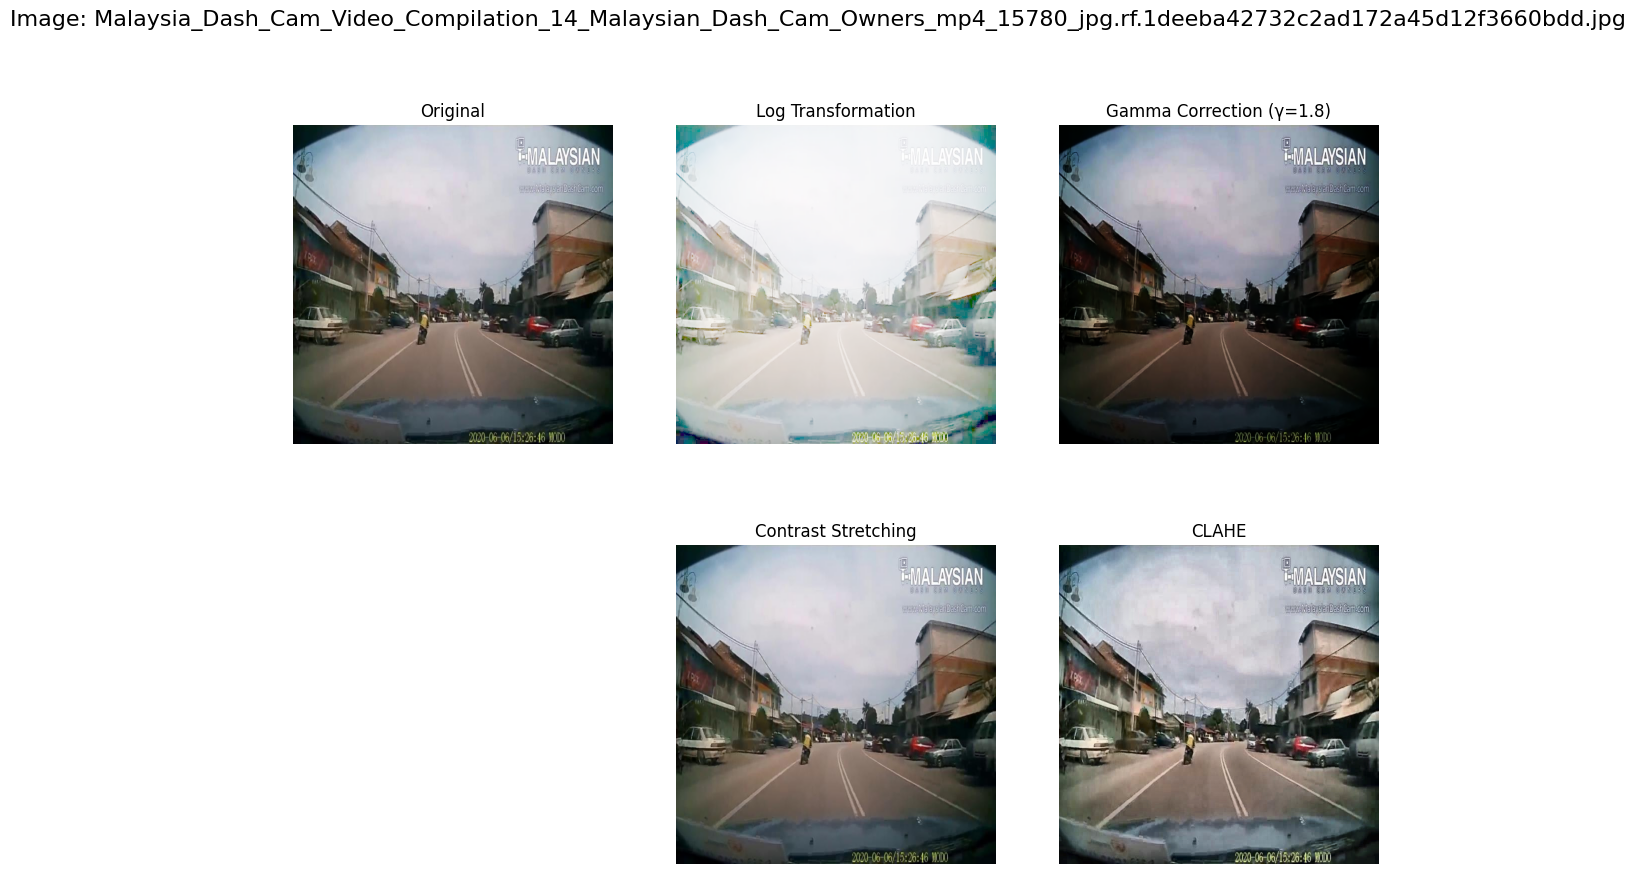

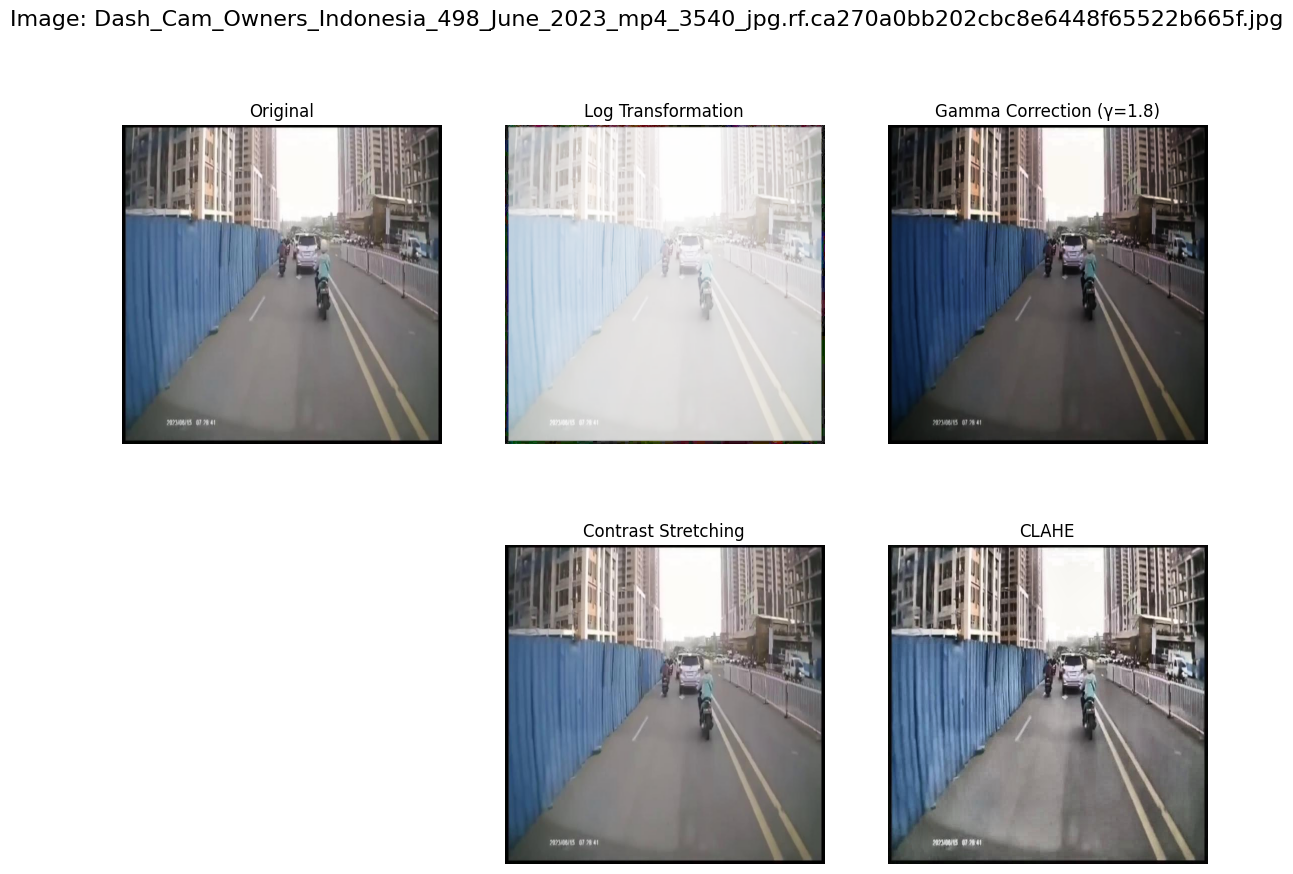

In [5]:
# ============================================================
# APPLY TRANSFORMATIONS & DISPLAY
# ============================================================

for img_path in sample_imgs:

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # for matplotlib

    # Apply transformations
    log_img = log_transformation(img)
    gamma_img = gamma_correction(img, gamma=1.8)
    stretch_img = contrast_stretching(img)
    clahe_img = clahe_equalization(img)

    # Plot outputs
    plt.figure(figsize=(14, 10))
    plt.suptitle(f"Image: {os.path.basename(img_path)}", fontsize=16)

    plt.subplot(2, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(log_img)
    plt.title("Log Transformation")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(gamma_img)
    plt.title("Gamma Correction (γ=1.8)")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(stretch_img)
    plt.title("Contrast Stretching")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(clahe_img)
    plt.title("CLAHE")
    plt.axis("off")

    plt.show()

# Define Filtering Functions

In [6]:
# ============================================================
# FILTER FUNCTIONS
# ============================================================

def mean_filter(img, ksize=5):
    return cv2.blur(img, (ksize, ksize))

def gaussian_filter(img, ksize=5, sigma=1):
    return cv2.GaussianBlur(img, (ksize, ksize), sigma)

def median_filter(img, ksize=5):
    return cv2.medianBlur(img, ksize)

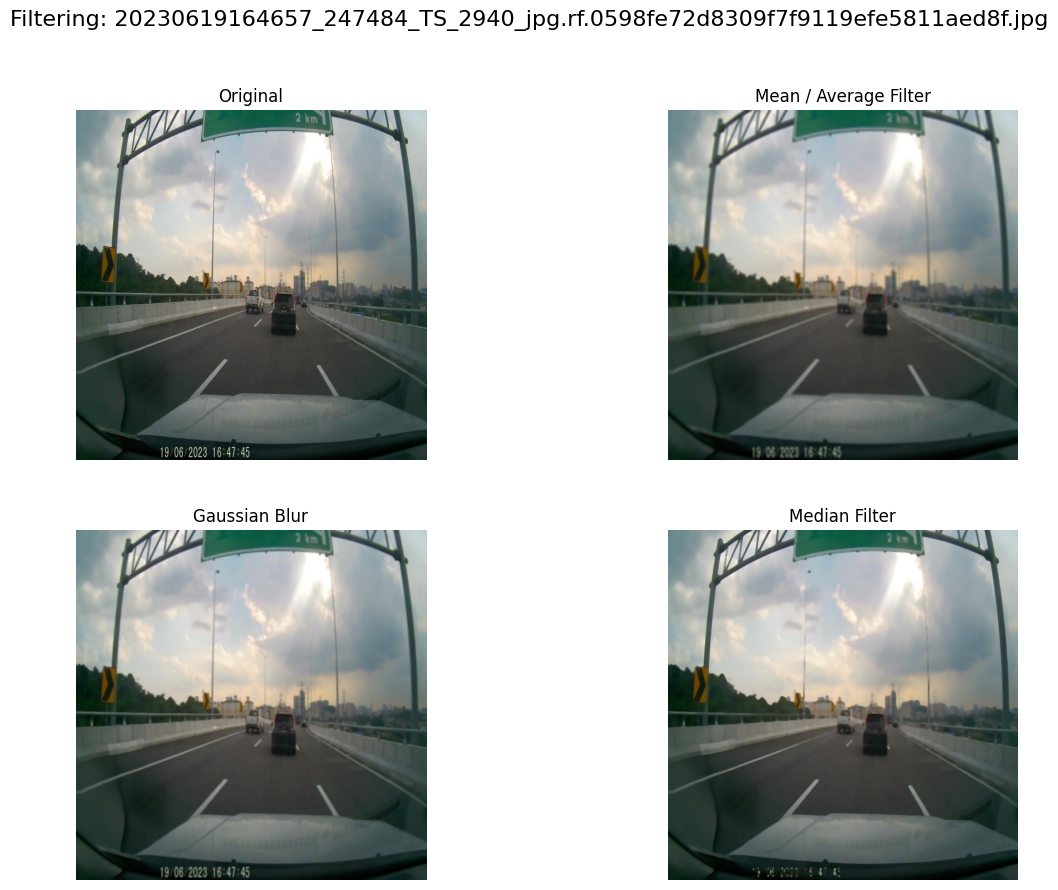

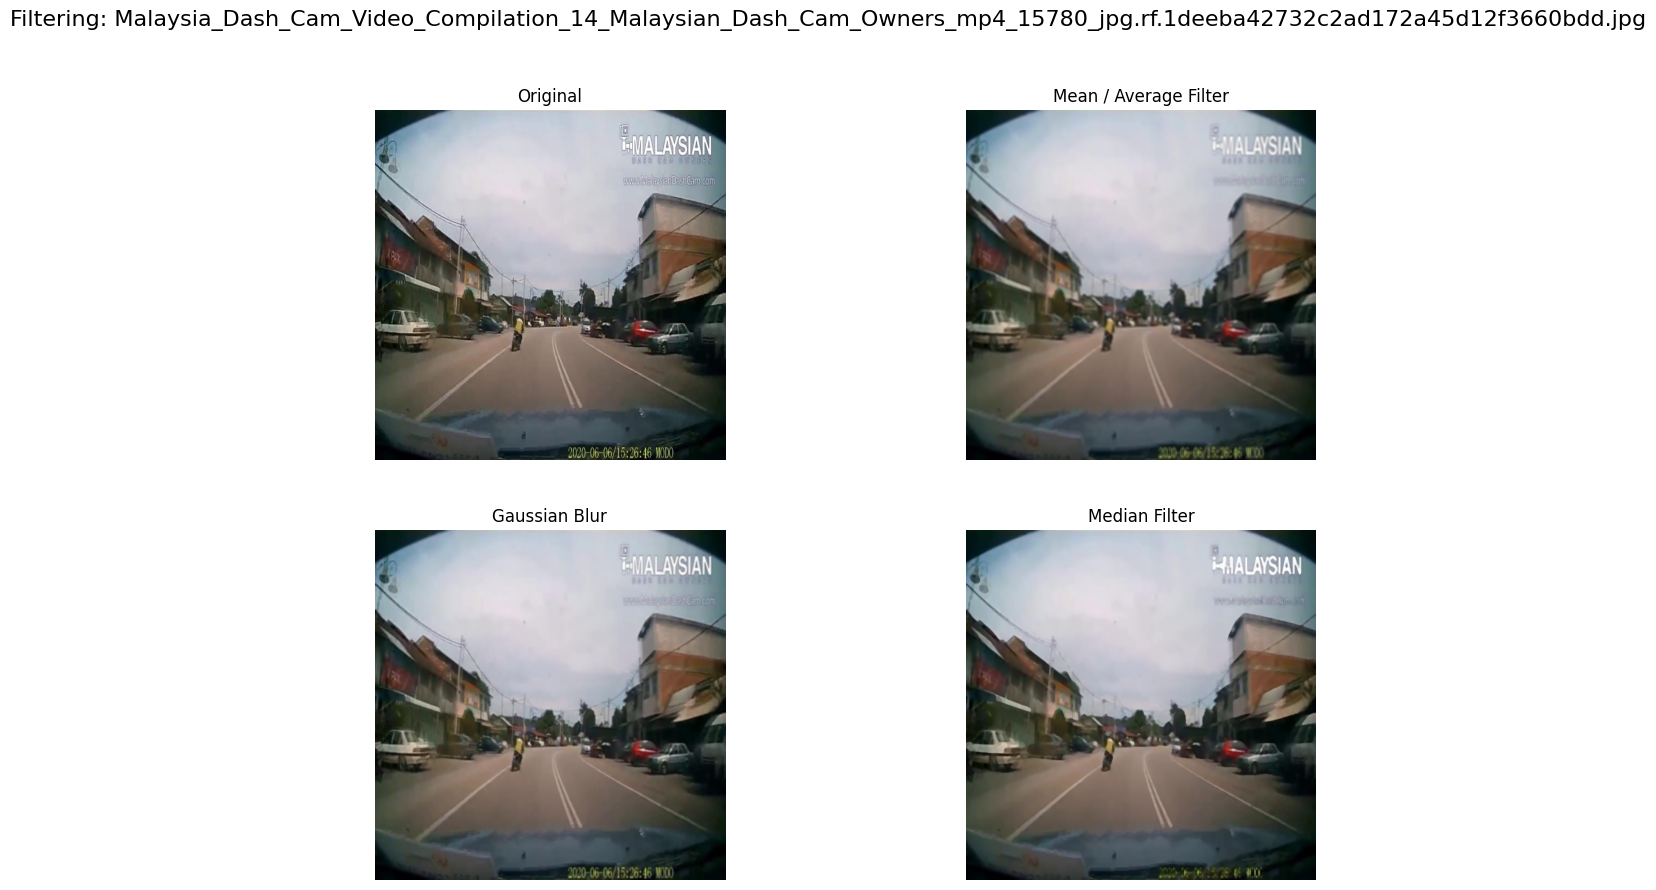

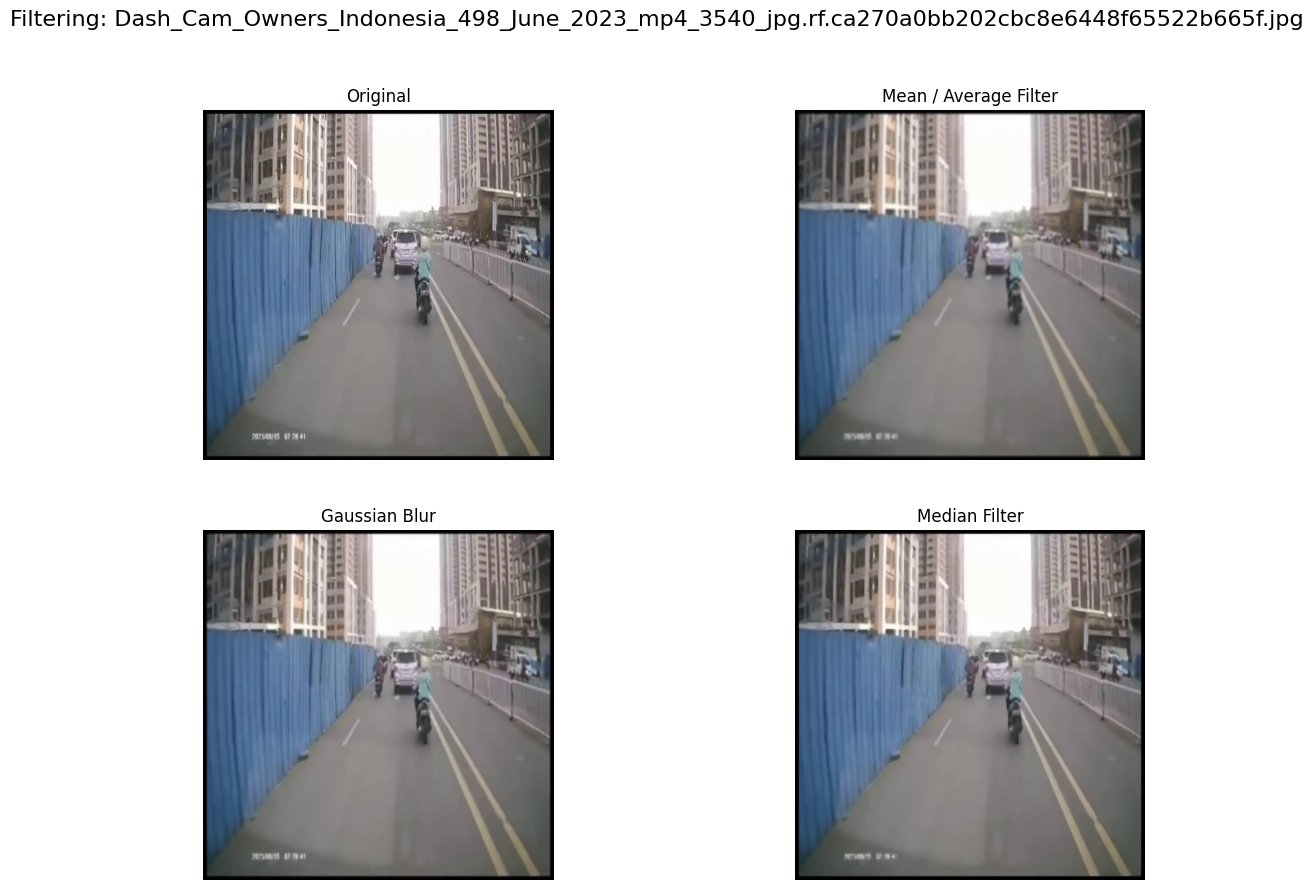

In [7]:
# ============================================================
# APPLY FILTERS & DISPLAY
# ============================================================

for img_path in sample_imgs:

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mean_img = mean_filter(img, ksize=5)
    gaussian_img = gaussian_filter(img, ksize=5, sigma=1)
    median_img = median_filter(img, ksize=5)

    plt.figure(figsize=(14, 10))
    plt.suptitle(f"Filtering: {os.path.basename(img_path)}", fontsize=16)

    plt.subplot(2, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(mean_img)
    plt.title("Mean / Average Filter")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(gaussian_img)
    plt.title("Gaussian Blur")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(median_img)
    plt.title("Median Filter")
    plt.axis("off")

    plt.show()

# Create the data.yaml file

In [8]:
%%writefile /kaggle/working/data.yaml
# ============================================================
# YOLOv12 Dataset Configuration for Instance Segmentation
# ============================================================

train: /kaggle/working/JPJ-1/train/images
val: /kaggle/working/JPJ-1/test/images
test: /kaggle/working/JPJ-1/test/images

# Number of classes
nc: 6

# Class names
names: ['divider-line','dotted-line','double-line','random-line','road-sign-line','solid-line']

Writing /kaggle/working/data.yaml


# Sample Visualization with Labels

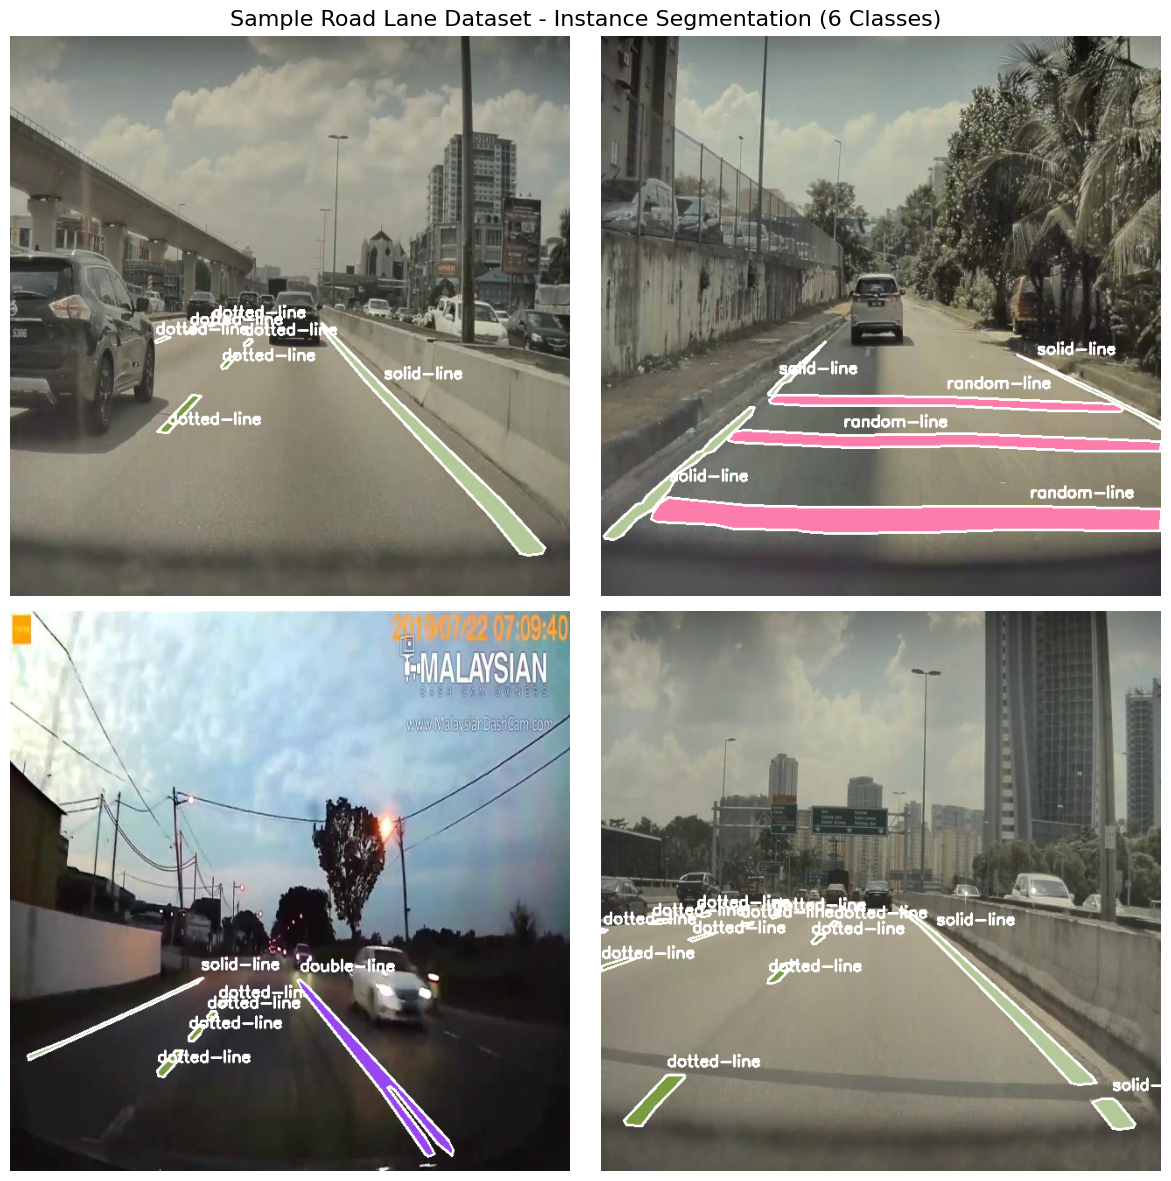

In [9]:
# ============================================================
# YOLOv11 Instance Segmentation Visualization (6 Classes)
# ============================================================

# Paths
image_dir = "/kaggle/working/JPJ-1/train/images"
label_dir = "/kaggle/working/JPJ-1/train/labels"

# Class names (must match YOLO class IDs)
CLASS_NAMES = [
    "divider-line",     # class 0
    "dotted-line",      # class 1
    "double-line",      # class 2
    "random-line",      # class 3
    "road-sign-line",   # class 4
    "solid-line"        # class 5
]

# Assign fixed colors to each class for consistent visualization
np.random.seed(42)  # for consistent colors across runs
CLASS_COLORS = {
    i: tuple(np.random.randint(50, 255, 3).tolist()) for i in range(len(CLASS_NAMES))
}

# Get random sample of 4 images
image_files = random.sample(os.listdir(image_dir), 4)

def visualize_image(img_path, label_path):
    """Visualize one image with segmentation masks or bboxes for all classes."""
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros((100, 100, 3), dtype=np.uint8)

    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            values = list(map(float, line.strip().split()))
            cls_id = int(values[0])
            coords = values[1:]
            class_name = CLASS_NAMES[cls_id] if cls_id < len(CLASS_NAMES) else f"class_{cls_id}"
            color = CLASS_COLORS.get(cls_id, (255, 255, 255))

            # Polygon segmentation (YOLOv12 mask format)
            if len(coords) > 4:
                pts = np.array(coords).reshape(-1, 2)
                pts[:, 0] *= w
                pts[:, 1] *= h
                pts = pts.astype(np.int32)
                cv2.fillPoly(overlay, [pts], color)
                cv2.polylines(overlay, [pts], True, (255, 255, 255), 2)
                cv2.putText(overlay, class_name, (pts[0][0], max(pts[0][1] - 10, 20)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            else:
                # Bounding box fallback
                xc, yc, bw, bh = coords
                x1, y1 = int((xc - bw / 2) * w), int((yc - bh / 2) * h)
                x2, y2 = int((xc + bw / 2) * w), int((yc + bh / 2) * h)
                cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
                cv2.putText(overlay, class_name, (x1, max(y1 - 5, 20)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return overlay

# ============================================================
# Show 4 Random Images (2x2 Grid)
# ============================================================
plt.figure(figsize=(12, 12))
for idx, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.rsplit('.', 1)[0] + ".txt")
    vis = visualize_image(img_path, label_path)

    plt.subplot(2, 2, idx + 1)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.suptitle("Sample Road Lane Dataset - Instance Segmentation (6 Classes)", fontsize=16)
plt.tight_layout()
plt.show()

# Setup

In [10]:
!pip -q install --upgrade ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00


In [11]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Point to data.yaml & quick sanity checks

In [12]:
DATA_YAML = "/kaggle/working/data.yaml"

# Show the YAML file for quick confirmation
print(open(DATA_YAML).read())

# Optional: basic file count checks (train/val/test)
import yaml
cfg = yaml.safe_load(open(DATA_YAML))
for split in ["train", "val", "test"]:
    if split in cfg and cfg[split]:
        img_dir = cfg[split]
        n = len(glob.glob(os.path.join(img_dir, "*.*")))
        print(f"{split:<5} -> {img_dir} : {n} files")

# ============================================================
# YOLOv12 Dataset Configuration for Instance Segmentation
# ============================================================

train: /kaggle/working/JPJ-1/train/images
val: /kaggle/working/JPJ-1/test/images
test: /kaggle/working/JPJ-1/test/images

# Number of classes
nc: 6

# Class names
names: ['divider-line','dotted-line','double-line','random-line','road-sign-line','solid-line']

train -> /kaggle/working/JPJ-1/train/images : 1021 files
val   -> /kaggle/working/JPJ-1/test/images : 112 files
test  -> /kaggle/working/JPJ-1/test/images : 112 files


# Train YOLOv11 (segmentation)

In [13]:
# Load a model
model = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

results = model.train(
    data=DATA_YAML,
    epochs=50,            # adjust as needed
    imgsz=640,
    batch=8,              # tune based on GPU memory
    workers=2,
    device=0,             # 0 for GPU, 'cpu' for CPU
    patience=10,          # early stopping
    save=True,
    save_period=-1,       # set >0 to save every N epochs
    pretrained=True,
    optimizer="auto",
    project="/kaggle/working/yolo11_runs",
    name="road_yolo11_seg",
    exist_ok=True,
    amp=True              # mixed precision (faster on modern GPUs)
)

print("Training finished. Best weights should be in 'best.pt' under the run directory.")

Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=road_yolo11_seg, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_ma

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.745      0.732      0.797      0.578      0.725      0.692      0.753      0.447
          divider-line         21         26      0.608      0.654      0.692      0.509      0.582      0.615      0.616      0.411
           dotted-line         96        621      0.918      0.739      0.872      0.623      0.834      0.665      0.775      0.417
           double-line          3          4      0.463          1      0.945      0.701      0.472          1      0.945       0.61
           random-line         19        104      0.802      0.548      0.664      0.395       0.77       0.49      0.603      0.294
        road-sign-line         14         24      0.815      0.667       0.73        0.5      0.829      0.608      0.718      0.439
            solid-line        105        203      0.866      0.783      0.882      0.742      0.862      0.772       0.86      0.508
Speed: 0.2ms preprocess, 5.2ms inference, 0.0ms loss, 6.5ms postproce

# Validation (mAP, precision/recall, confusion matrix)

In [14]:
# Locate best weights from the run folder
run_dir = results.save_dir if hasattr(results, "save_dir") else "/kaggle/working/yolo11_runs/road_yolo11_seg"
best_ckpt = os.path.join(run_dir, "weights", "best.pt")
print("Using weights:", best_ckpt)

model = YOLO(best_ckpt)
val_metrics = model.val(split="val")   # uses val set in data.yaml

# The .val() call prints a summary and saves plots (PR curves, confusion, F1, etc.)
# You can also access metrics programmatically:
try:
    # For segmentation: metrics.box.map and metrics.seg.map exist on recent ultralytics
    print("Box  mAP50-95:", getattr(val_metrics.box, "map", None))
    print("Mask mAP50-95:", getattr(val_metrics.seg, "map", None))
except:
    pass

Using weights: /kaggle/working/yolo11_runs/road_yolo11_seg/weights/best.pt
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,835,738 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 913.2±361.4 MB/s, size: 40.9 KB)
val: Scanning /kaggle/working/JPJ-1/test/labels.cache... 112 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 112/112 209.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.6it/s 4.5s


invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.746      0.732      0.798      0.578      0.687      0.693      0.728      0.427
          divider-line         21         26      0.608      0.654       0.69      0.498      0.561      0.615      0.614      0.411
           dotted-line         96        621       0.92      0.741      0.876      0.629      0.807      0.658      0.759      0.403
           double-line          3          4      0.464          1      0.945      0.701       0.46          1      0.945       0.61
           random-line         19        104        0.8      0.548      0.664      0.398      0.744      0.519      0.597      0.293
        road-sign-line         14         24      0.818      0.667       0.73      0.501      0.694      0.583      0.594      0.338
            solid-line        105        203      0.866      0.783      0.881      0.743      0.859      0.779      0.858      0.508
Speed: 4.2ms preprocess, 6.9ms inference, 0.0ms loss, 6.3ms postproce

# Test set evaluation

In [15]:
# Evaluate on test split if defined in data.yaml
try:
    test_metrics = model.val(split="test")
    try:
        print("Test Box  mAP50-95:", getattr(test_metrics.box, "map", None))
        print("Test Mask mAP50-95:", getattr(test_metrics.seg, "map", None))
    except:
        pass
except Exception as e:
    print("Test evaluation skipped or failed:", e)

Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1149.8±430.1 MB/s, size: 41.7 KB)
val: Scanning /kaggle/working/JPJ-1/test/labels.cache... 112 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 112/112 231.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.4it/s 4.8s


invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.746      0.732      0.798      0.578      0.687      0.693      0.728      0.427
          divider-line         21         26      0.608      0.654       0.69      0.498      0.561      0.615      0.614      0.411
           dotted-line         96        621       0.92      0.741      0.876      0.629      0.807      0.658      0.759      0.403
           double-line          3          4      0.464          1      0.945      0.701       0.46          1      0.945       0.61
           random-line         19        104        0.8      0.548      0.664      0.398      0.744      0.519      0.597      0.293
        road-sign-line         14         24      0.818      0.667       0.73      0.501      0.694      0.583      0.594      0.338
            solid-line        105        203      0.866      0.783      0.881      0.743      0.859      0.779      0.858      0.508
Speed: 3.7ms preprocess, 5.9ms inference, 0.0ms loss, 7.3ms postproce

# Predict & visualize a few samples from the test set


0: 640x640 1 divider-line, 6 dotted-lines, 1 road-sign-line, 1 solid-line, 16.0ms
1: 640x640 1 divider-line, 3 dotted-lines, 10 random-lines, 2 road-sign-lines, 1 solid-line, 16.0ms
2: 640x640 9 dotted-lines, 2 solid-lines, 16.0ms
3: 640x640 10 dotted-lines, 2 solid-lines, 16.0ms
Speed: 1.5ms preprocess, 16.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 divider-line, 6 dotted-lines, 1 road-sign-line, 1 solid-line, 7.2ms
1: 640x640 1 divider-line, 3 dotted-lines, 10 random-lines, 2 road-sign-lines, 1 solid-line, 7.2ms
2: 640x640 9 dotted-lines, 2 solid-lines, 7.2ms
3: 640x640 10 dotted-lines, 2 solid-lines, 7.2ms
Speed: 1.2ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


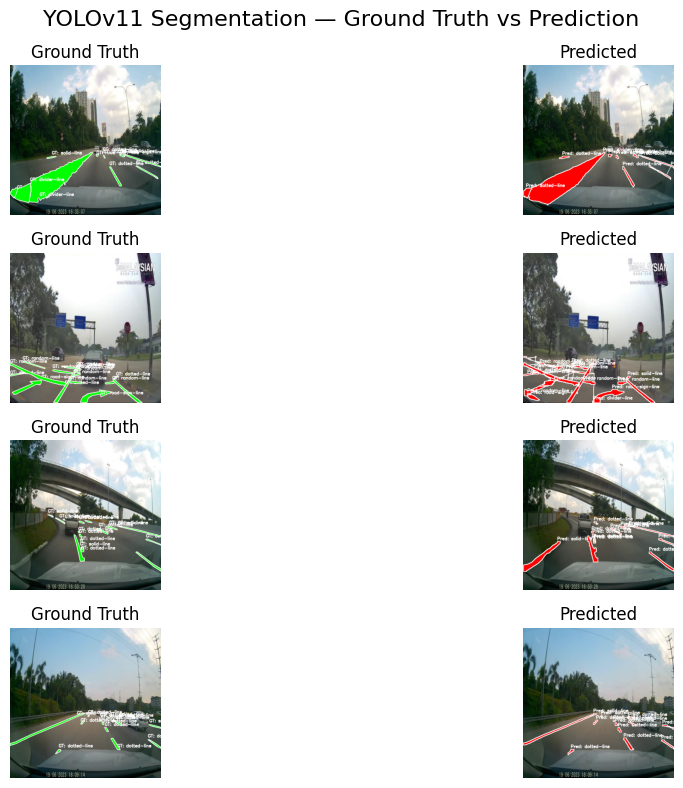

In [16]:
# ============================================================
# YOLOv11 Segmentation — Predicted vs Ground Truth Comparison
# ============================================================

import os, glob, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# Pick a few random test images
test_dir = cfg.get("test")
label_dir = test_dir.replace("/images", "/labels")  # assumes standard YOLO structure

sample_imgs = []
if test_dir and os.path.isdir(test_dir):
    all_imgs = [p for p in glob.glob(os.path.join(test_dir, "*.*"))
                if p.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))]
    sample_imgs = random.sample(all_imgs, min(4, len(all_imgs)))

# ------------------------------------------------------------
# Helper to draw polygons from YOLO label file (Ground Truth)
# ------------------------------------------------------------
def draw_gt_polygons(img_path, label_path, class_names=["divider-line",     # class 0
    "dotted-line",      # class 1
    "double-line",      # class 2
    "random-line",      # class 3
    "road-sign-line",   # class 4
    "solid-line"]):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                vals = list(map(float, line.strip().split()))
                cls_id = int(vals[0])
                coords = vals[1:]
                if len(coords) > 4:
                    pts = np.array(coords).reshape(-1, 2)
                    pts[:, 0] *= w
                    pts[:, 1] *= h
                    pts = pts.astype(np.int32)
                    color = (0, 255, 0)  # green for GT
                    cv2.fillPoly(overlay, [pts], color)
                    cv2.polylines(overlay, [pts], True, (255, 255, 255), 2)
                    label = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
                    cv2.putText(overlay, f"GT: {label}", (pts[0][0], pts[0][1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    else:
        print(f"No label file found for {os.path.basename(img_path)}")

    return overlay

# ------------------------------------------------------------
# Helper to draw predicted polygons
# ------------------------------------------------------------
def draw_pred_polygons(result):
    img = result.orig_img.copy()

    if getattr(result, "masks", None) is not None and result.masks is not None:
        for i, seg in enumerate(result.masks.xy):
            poly = np.array(seg, dtype=np.int32)
            color = (0, 0, 255)  # red for predictions
            cv2.fillPoly(img, [poly], color)
            cv2.polylines(img, [poly], True, (255, 255, 255), 2)
            if getattr(result, "names", None) is not None and getattr(result.boxes, "cls", None) is not None:
                cls_id = int(result.boxes.cls[i].item())
                label = result.names.get(cls_id, str(cls_id)) if isinstance(result.names, dict) else str(cls_id)
                x, y = poly[0]
                cv2.putText(img, f"Pred: {label}", (int(x), int(y) - 6),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    else:
        print("⚠️ No predicted masks found for:", result.path)

    return img

# ------------------------------------------------------------
# Run inference on test set
# ------------------------------------------------------------
preds = model.predict(source=sample_imgs, imgsz=640, conf=0.25, device=0, save=False)

# ------------------------------------------------------------
# Run inference on test set
# ------------------------------------------------------------
preds = model.predict(source=sample_imgs, imgsz=640, conf=0.25, device=0, save=False)

# ------------------------------------------------------------
# Plot Predicted vs Ground Truth
# ------------------------------------------------------------
plt.figure(figsize=(14, 8))
for i, result in enumerate(preds):
    img_path = result.path
    label_path = os.path.join(label_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
    
    # Prepare visualizations
    vis_pred = draw_pred_polygons(result)
    vis_gt = draw_gt_polygons(img_path, label_path)

    vis_pred_rgb = cv2.cvtColor(vis_pred, cv2.COLOR_BGR2RGB)
    vis_gt_rgb = cv2.cvtColor(vis_gt, cv2.COLOR_BGR2RGB)

    # Show side by side
    plt.subplot(len(preds), 2, 2*i + 1)
    plt.imshow(vis_gt_rgb)
    #plt.title(f"GT: {os.path.basename(img_path)}")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(len(preds), 2, 2*i + 2)
    plt.imshow(vis_pred_rgb)
    plt.title("Predicted")
    plt.axis("off")

plt.suptitle("YOLOv11 Segmentation — Ground Truth vs Prediction", fontsize=16)
plt.tight_layout()
plt.show()

In [17]:
DATA_YAML = "/kaggle/working/data.yaml"
BASE_PATH = "/kaggle/working/JPJ-1"
LABELED_PATH = "/kaggle/working/mixmatch_labeled"
UNLABELED_PATH = "/kaggle/working/mixmatch_unlabeled"

os.makedirs(LABELED_PATH + "/images", exist_ok=True)
os.makedirs(LABELED_PATH + "/labels", exist_ok=True)
os.makedirs(UNLABELED_PATH + "/images", exist_ok=True)
os.makedirs(UNLABELED_PATH + "/labels", exist_ok=True)

all_imgs = glob.glob(os.path.join(BASE_PATH, "train/images", "*.*"))
random.shuffle(all_imgs)
split_idx = int(len(all_imgs) * 0.2)
labeled_imgs = all_imgs[:split_idx]
unlabeled_imgs = all_imgs[split_idx:]

def copy_data(img_list, dst_dir):
    for img in img_list:
        base = os.path.splitext(os.path.basename(img))[0]
        lbl = img.replace("images", "labels").rsplit(".", 1)[0] + ".txt"
        shutil.copy(img, os.path.join(dst_dir, "images", os.path.basename(img)))
        if os.path.exists(lbl):
            shutil.copy(lbl, os.path.join(dst_dir, "labels", base + ".txt"))

copy_data(labeled_imgs, LABELED_PATH)
copy_data(unlabeled_imgs, UNLABELED_PATH)

print(f"✅ Split done → {len(labeled_imgs)} labeled | {len(unlabeled_imgs)} unlabeled")

✅ Split done → 204 labeled | 817 unlabeled


In [18]:
# ============================================================
# STEP 2️⃣ : Augmentations
# ============================================================
weak_aug = A.Compose([
    A.Resize(640, 640),
    A.HorizontalFlip(p=0.5),
])

strong_aug = A.Compose([
    A.Resize(640, 640),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.4),
    A.MotionBlur(p=0.3),
    A.GaussNoise(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
])

def mixup(img1, img2, alpha=0.75):
    lam = np.random.beta(alpha, alpha)
    return (lam * img1 + (1 - lam) * img2).astype(np.uint8), lam

In [19]:
# ============================================================
# STEP 3️⃣ : Config
# ============================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
lambda_u = 0.5   # weight for unsupervised loss
conf_thresh = 0.6
EPOCHS = 10
MIXMATCH_YAML = "/kaggle/working/mixmatch_labeled.yaml"

# create yaml file for labeled subset
with open(MIXMATCH_YAML, "w") as f:
    f.write(f"""
train: {LABELED_PATH}/images
val: {BASE_PATH}/test/images
nc: 6
names: ['divider-line','dotted-line','double-line','random-line','road-sign-line','solid-line']
""")

In [20]:
# ============================================================
# STEP 4️⃣ : MixMatch Training Loop
# ============================================================
for epoch in range(EPOCHS):
    print(f"\n🌱 Epoch {epoch+1}/{EPOCHS}")

    # Reinitialize YOLO model each epoch (avoids KeyError: 'model')
    model = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")

    # === Step 1: Train on labeled data ===
    model.train(
        data=MIXMATCH_YAML,
        epochs=5,
        imgsz=640,
        batch=8,
        device=0,
        verbose=False,
        name=f"mixmatch_epoch_{epoch+1}",
        exist_ok=True
    )
    # === Step 2: Pseudo-label + MixMatch consistency ===
    for unlabeled_path in tqdm(unlabeled_imgs[:60], desc=f"MixMatch Step {epoch+1}"):
        img = cv2.imread(unlabeled_path)
        if img is None:
            continue

        weak_img = weak_aug(image=img)["image"]
        strong_img = strong_aug(image=img)["image"]

        preds = model.predict(source=weak_img, conf=conf_thresh, imgsz=640, save=False, verbose=False)
        if not preds:
            continue

        for r in preds:
            if r.masks is None:
                continue

            # Mix unlabeled with a random labeled sample
            rand_img_path = random.choice(glob.glob(os.path.join(LABELED_PATH, "images", "*")))
            img_l = cv2.imread(rand_img_path)
            img_l = cv2.resize(img_l, (640, 640))

            mixed_img, lam = mixup(strong_img, img_l)

            # Forward pass consistency (unsupervised)
            pseudo_pred = model.predict(source=mixed_img, conf=0.25, imgsz=640, save=False, verbose=False)

            # Compute IoU-based unsupervised loss
            if not pseudo_pred or r.masks is None:
                continue

            weak_masks = [seg for seg in r.masks.xy]
            strong_masks = [seg for s in pseudo_pred for seg in getattr(s.masks, "xy", [])]
            if weak_masks and strong_masks:
                weak_mask = np.zeros((640, 640), np.uint8)
                strong_mask = np.zeros((640, 640), np.uint8)
                cv2.fillPoly(weak_mask, [np.int32(weak_masks[0])], 1)
                cv2.fillPoly(strong_mask, [np.int32(strong_masks[0])], 1)
                intersection = np.logical_and(weak_mask, strong_mask).sum()
                union = np.logical_or(weak_mask, strong_mask).sum()
                iou = intersection / (union + 1e-6)
                loss_unsup = (1 - iou)
                unsup_loss = lambda_u * loss_unsup

    print(f"✅ Completed Epoch {epoch+1} | Unsupervised consistency loss applied.")

print("🏁 MixMatch semi-supervised training complete.")


🌱 Epoch 1/10
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mixmatch_epoch_1, nbs=64, nms=False, opset=None, optimize=False, 

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.919      0.189      0.234      0.159      0.866      0.146      0.167     0.0669
Speed: 0.3ms preprocess, 3.7ms inference, 0.0ms loss, 10.4ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_1


MixMatch Step 1: 100%|██████████| 60/60 [00:02<00:00, 20.52it/s]


✅ Completed Epoch 1 | Unsupervised consistency loss applied.

🌱 Epoch 2/10
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mixm

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.919      0.189      0.234      0.159      0.866      0.146      0.167     0.0669
Speed: 0.3ms preprocess, 4.0ms inference, 0.0ms loss, 9.4ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_2


MixMatch Step 2: 100%|██████████| 60/60 [00:02<00:00, 21.13it/s]


✅ Completed Epoch 2 | Unsupervised consistency loss applied.

🌱 Epoch 3/10
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mixm

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.919      0.189      0.234      0.159      0.866      0.146      0.167     0.0669
Speed: 0.5ms preprocess, 4.4ms inference, 0.0ms loss, 10.4ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_3


MixMatch Step 3: 100%|██████████| 60/60 [00:02<00:00, 21.05it/s]


✅ Completed Epoch 3 | Unsupervised consistency loss applied.

🌱 Epoch 4/10
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mixm

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.919      0.189      0.234      0.159      0.866      0.146      0.167     0.0669
Speed: 0.5ms preprocess, 4.6ms inference, 0.0ms loss, 9.6ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_4


MixMatch Step 4: 100%|██████████| 60/60 [00:02<00:00, 21.27it/s]


✅ Completed Epoch 4 | Unsupervised consistency loss applied.

🌱 Epoch 5/10
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mixm

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.919      0.189      0.234      0.159      0.866      0.146      0.167     0.0669
Speed: 0.4ms preprocess, 4.0ms inference, 0.0ms loss, 9.5ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_5


MixMatch Step 5: 100%|██████████| 60/60 [00:02<00:00, 20.40it/s]


✅ Completed Epoch 5 | Unsupervised consistency loss applied.

🌱 Epoch 6/10
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mixm

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.919      0.189      0.234      0.159      0.866      0.146      0.167     0.0669
Speed: 0.7ms preprocess, 4.5ms inference, 0.0ms loss, 9.9ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_6


MixMatch Step 6: 100%|██████████| 60/60 [00:02<00:00, 21.65it/s]


✅ Completed Epoch 6 | Unsupervised consistency loss applied.

🌱 Epoch 7/10
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mixm

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.919      0.189      0.234      0.159      0.866      0.146      0.167     0.0669
Speed: 0.3ms preprocess, 4.6ms inference, 0.0ms loss, 9.1ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_7


MixMatch Step 7: 100%|██████████| 60/60 [00:02<00:00, 21.52it/s]


✅ Completed Epoch 7 | Unsupervised consistency loss applied.

🌱 Epoch 8/10
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mixm

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.919      0.189      0.234      0.159      0.866      0.146      0.167     0.0669
Speed: 0.3ms preprocess, 3.9ms inference, 0.0ms loss, 10.7ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_8


MixMatch Step 8: 100%|██████████| 60/60 [00:02<00:00, 21.76it/s]


✅ Completed Epoch 8 | Unsupervised consistency loss applied.

🌱 Epoch 9/10
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mixm

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.919      0.189      0.234      0.159      0.866      0.146      0.167     0.0669
Speed: 0.3ms preprocess, 4.8ms inference, 0.0ms loss, 8.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_9


MixMatch Step 9: 100%|██████████| 60/60 [00:02<00:00, 20.61it/s]


✅ Completed Epoch 9 | Unsupervised consistency loss applied.

🌱 Epoch 10/10
Transferred 499/561 items from pretrained weights
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mixmatch_labeled.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=mix

invalid value encountered in less
invalid value encountered in less


                   all        112        982      0.919      0.189      0.234      0.159      0.866      0.146      0.167     0.0669
Speed: 0.3ms preprocess, 4.2ms inference, 0.0ms loss, 10.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/mixmatch_epoch_10


MixMatch Step 10: 100%|██████████| 60/60 [00:02<00:00, 21.80it/s]

✅ Completed Epoch 10 | Unsupervised consistency loss applied.
🏁 MixMatch semi-supervised training complete.
